In [1]:
import os, sys; sys.path.append("/".join(os.getcwd().split("/")[:-1]))

In [2]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from data.dbaasp.dbaasp.peptide import Peptide
import json
from typing import *
from sklearn.feature_selection import r_regression

In [3]:
# Material colors
COLORS = ['#1C7ED6', '#77DD77', '#FFB347', '#FF6961', '#17BECF', '#F4D35E', "#ADFF2F", "#FF8200"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=COLORS)
plt.rcParams.update({'font.size': 14})

In [5]:
ESKAPEE = {
    "Enterococcus faecium",
    "Staphylococcus aureus",
    "Klebsiella pneumoniae",
    "Acinetobacter baumannii",
    "Pseudomonas aeruginosa",
    "Escherichia coli"
}

def get_eskape_activities(peptide: Peptide, alpha: float = 8.) -> Tuple[dict, dict]:
    targets = [t for t in peptide.targets if t.activityMeasureType == 'MIC']
    species = {}
    for t in targets:
        if 'enterobacter' in t.specie.lower():  # Put all enterobacter under the same name (Enterobacter spp.)
            t.set_name('Enterobacter')
        if t.specie not in species:
            species[t.specie] = []  # Count, activity sum
        mi, ma = t.minActivity, t.maxActivity
        if mi == ma:
            continue    # We want to estimate the range across a specie,but if it was tested on only one strand, there is no information there

        if math.isnan(mi) or math.isnan(ma):
            continue

        if ma == float('inf'):
            if alpha > 0: ma = mi * alpha
            else: continue
        elif mi == 0:
            if alpha > 0: mi = ma / alpha
            else: continue
        if mi < 0:
            print("Negative value", mi, "Sequence: ", peptide.sequence, "Specie: ", t.specie)
        species[t.specie].append((mi, ma))

    consensus_activities = {}
    points_mics = {}
    for specie, act in species.items():
        if specie not in ESKAPEE:
            continue
        if len(act) == 0:
            continue    # No range of activity (For different strand)
        mins = [np.log10(a[0]) for a in act]
        maxs = [np.log10(a[1]) for a in act]
        consensus_activities[specie] = np.mean(mins + maxs)
        points_mics[specie] = mins + maxs
    return consensus_activities, points_mics

In [6]:
pred = {specie: [] for specie in ESKAPEE}
targets = {specie: [] for specie in ESKAPEE}

with open('../data/.cache/DBAASP_raw.json', 'r') as f:
    data = json.load(f)
count = 0
for i, sample in enumerate(data):
    peptide = Peptide(sample)
    if peptide.complexity != "Monomer":
        continue
    consensus_activities, points_mics = get_eskape_activities(peptide, alpha=0)
    if len(consensus_activities) != 0:
        count += 1
        deltas = {t: np.array(points_mics[t]) - consensus_activities[t] for t in consensus_activities}
        for t in consensus_activities.keys():
            pred[t].append(np.array(points_mics[t]))
            targets[t].append(np.full_like(points_mics[t], fill_value=consensus_activities[t]))
pred = {key: np.concatenate(values) for key, values in pred.items()}
targets = {key: np.concatenate(values) for key, values in targets.items()}

# Setup
For each peptide entry in the DBAASP database, there are multiple annotations. There can be a MIC for different targets, and there can also be multiple measure of MIC for the same species, but for different strains. Some annotations are a range. This means that the peptide has been tested for a distribution of strains for this specie, and the range correspond to the range of mic for the given specie. Also, some have an undetermined range, meaning that they didn't found any maximum MIC. This should mean that a strain is resistant to the peptide. We ignore those samples for this correlation experiment.

Since our project aims at predicting the consensus MIC for a peptide and a specie, we want to see the correlation of the MIC ranges. To do so, we compute the log mean (consensus value), and assumes the max and min as point values. The consensus is considered as the reference, and we try to see the correlation and difference between the point MICs and the consensus.

In [7]:
ESKAPEE = [
    "Enterococcus faecium",
    "Staphylococcus aureus",
    "Klebsiella pneumoniae",
    "Acinetobacter baumannii",
    "Pseudomonas aeruginosa",
    "Escherichia coli"
]
if not os.path.exists(".cache/figs"):
    os.makedirs(".cache/figs")

Enterococcus faecium
Count:  1970
MAE:  0.19246984991797322
MSE:  0.05114220350592895
PCC:  0.9347317177650711


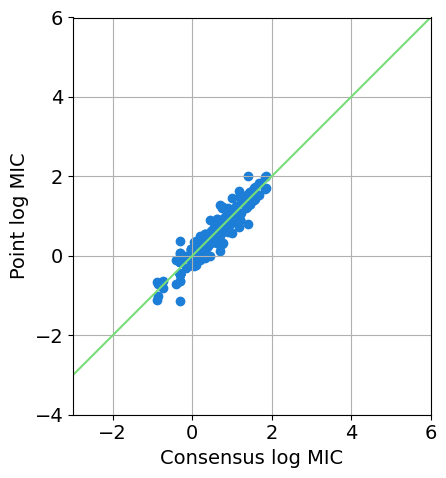

Staphylococcus aureus
Count:  1970
MAE:  0.19674721076880747
MSE:  0.0675659950374577
PCC:  0.919378702020124


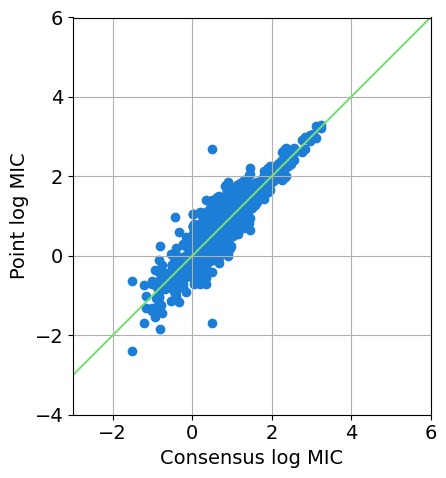

Klebsiella pneumoniae
Count:  1970
MAE:  0.21085634252638466
MSE:  0.0789232153617725
PCC:  0.9057600988341161


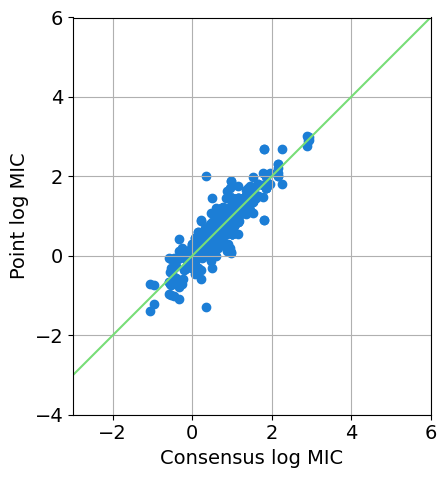

Acinetobacter baumannii
Count:  1970
MAE:  0.20613131790256345
MSE:  0.07361460506450797
PCC:  0.8846939303798032


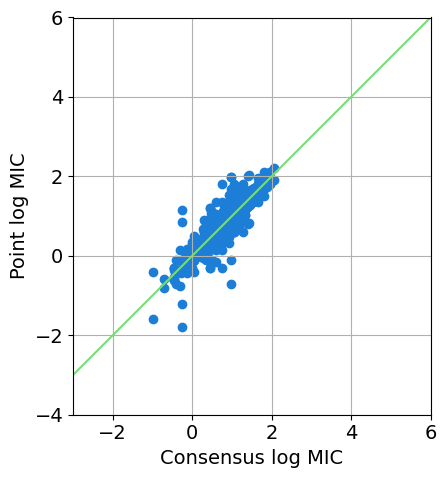

Pseudomonas aeruginosa
Count:  1970
MAE:  0.20804177249591982
MSE:  0.0755162672631181
PCC:  0.9129071610558929


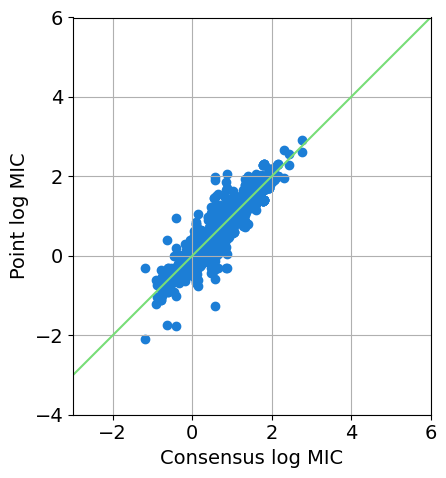

Escherichia coli
Count:  1970
MAE:  0.2091791960667962
MSE:  0.07546067626729097
PCC:  0.9179992718147661


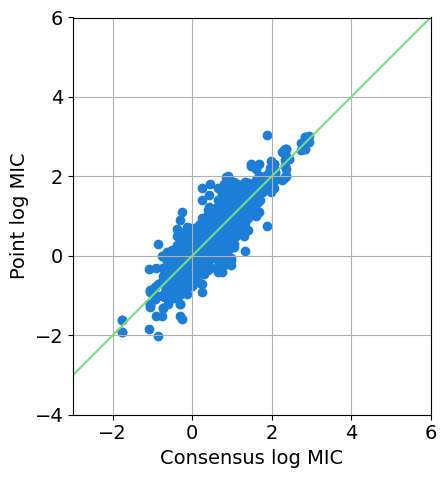

In [8]:
for specie in ESKAPEE:
    print("=" * 100)
    print(specie)
    print("Count: ", count)
    print("MAE: ", np.mean(np.abs(pred[specie] - targets[specie])))
    print("MSE: ", np.mean((pred[specie] - targets[specie]) ** 2))
    print("PCC: ", r_regression(pred[specie][:, None], targets[specie])[0])
    plt.figure(figsize=(5, 5))
    # plt.subplot(1, 2, 1)
    plt.scatter(targets[specie], pred[specie])
    plt.xlabel('Consensus log MIC')
    plt.ylabel('Point log MIC')
    plt.plot([-3, 6], [-3, 6], color=COLORS[1])
    plt.xlim(-3, 6)
    plt.ylim(-3, 6)
    plt.gca().set_aspect('equal', adjustable='box')
    # Match y-ticks to x-ticks
    plt.yticks(plt.xticks()[0])
    # plt.subplot(1, 2, 2)
    # plt.hist(pred[specie] - targets[specie], bins=50, range=(-2,2))
    # plt.suptitle(specie)
    plt.grid()
    plt.tight_layout(h_pad=-1)
    plt.savefig(".cache/figs/{}.png".format(specie))
    plt.show()